# Introduction
This section describes the demographic analysis for the residential building loads based on the RBSA data.  The methodology identifies the key demographic variables and their sensitivities. The demographic sensitivities are necessary to partition the base loadshapes according to demographic variables. The sensitivities are then used to project base loadshapes to other regions where the demographics may differ from the RBSA region.


## Step 1: Obtain the RBSA city zipcodes
This step loads the zipcodes of the RBSA sites and the corresponding city name

In [2]:
import pandas as pd
cities = pd.read_csv("cities.csv",index_col=[0],names=["zipcode","city"])
print("%d cities found..." % len(cities))
with pd.option_context("display.max_rows",10):
    print(cities)

89 cities found...
                     city
zipcode                  
59421          CASCADE,MT
59601           HELENA,MT
59715          BOZEMAN,MT
59759        WHITEHALL,MT
59840         HAMILTON,MT
...                   ...
99206          SPOKANE,WA
99208          SPOKANE,WA
99224          SPOKANE,WA
99336        KENNEWICK,WA
99353    WEST RICHLAND,WA

[89 rows x 1 columns]


## Load the census data
This step loads the census data for the zipcodes identifies in Step 1.  The data extracted includes
* City - the name of the city (for label purposes)
* Density - the population density
* Occupancy - the home occupancy (fraction of homes that have residents)
* Value - the median home price (in thousands of US dollars)
* Income - the median home income (in thousands of US dollars annually)

In [3]:
from uszipcode import SearchEngine

search = SearchEngine(simple_zipcode=True)
citydata = {}
for zipcode in list(cities.index):
    data = search.by_zipcode(str(zipcode)).to_dict()
    #print(data.keys())
    try:
        citydata[zipcode] = {
            "City":data["major_city"]+" "+data["state"],
            "Latitude":data["lat"],
            "Longitude":data["lng"],
            "Population":data["population"],
            "Density":int(data["population_density"]),
            "Occupancy":int(data["occupied_housing_units"] / data["housing_units"] * 100)/100,
            "Value":int(data["median_home_value"]/100)/10,
            "Income":int(data["median_household_income"]/100)/10}
    except:
        print("WARNING: error processing %s rbs, skipping" % (zipcode))
demographics = pd.DataFrame.from_dict(citydata,"index")
demographics.index.name = "Zipcode"
demographics.to_csv("demographics.csv")
with pd.option_context("display.max_rows",10):
    print(demographics)

                     City  Latitude  Longitude  Population  Density  \
Zipcode                                                               
59421          Cascade MT     47.20    -111.70        1831        3   
59601           Helena MT     46.50    -112.10       29283      212   
59715          Bozeman MT     45.70    -111.00       31567       68   
59759        Whitehall MT     45.90    -112.20        3643        8   
59840         Hamilton MT     46.20    -114.20       13052       28   
...                   ...       ...        ...         ...      ...   
99206          Spokane WA     47.60    -117.20       34802     1487   
99208          Spokane WA     47.80    -117.50       49193     1001   
99224          Spokane WA     47.60    -117.50       18289      156   
99336        Kennewick WA     46.21    -119.18       48753     3653   
99353    West Richland WA     46.32    -119.40       13306      511   

         Occupancy  Value  Income  
Zipcode                            
5942

## Examine the census data

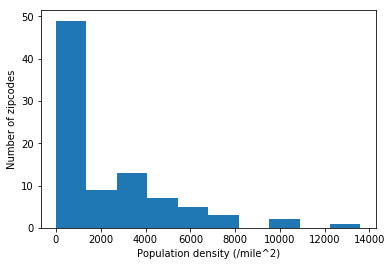

Figure 1: Population density histogram


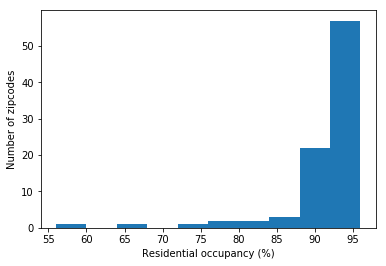

Figure 2: Residential occupancy histogram


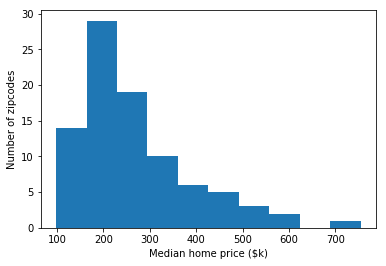

Figure 3: Median home price


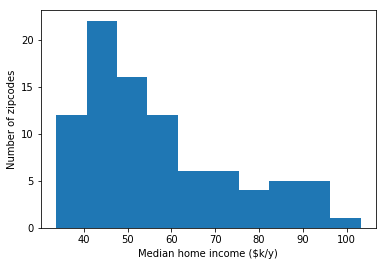

Figure 3: Median home income histogram


In [4]:
import matplotlib.pyplot as plt

plt.hist(demographics.Density)
plt.xlabel("Population density (/mile^2)")
plt.ylabel("Number of zipcodes")
plt.show()
print("Figure 1: Population density histogram")

plt.hist(100*demographics.Occupancy)
plt.xlabel("Residential occupancy (%)")
plt.ylabel("Number of zipcodes")
plt.show()
print("Figure 2: Residential occupancy histogram")

plt.hist(demographics.Value)
plt.xlabel("Median home price ($k)")
plt.ylabel("Number of zipcodes")
plt.show()
print("Figure 3: Median home price")

plt.hist(demographics.Income)
plt.xlabel("Median home income ($k/y)")
plt.ylabel("Number of zipcodes")
plt.show()
print("Figure 3: Median home income histogram")

The data and ranges look reasonable. Next let's look at the geographic distribution of the data.  First we need to download the geopandas shape files for states and zipcodes. You only need to do this once, so this takes a while the first time, but once the files are downloaded nothing really happens.

In [5]:
import pathlib
import urllib.request

states_filename = "tl_2017_us_state.zip"
states_url = f"https://www2.census.gov/geo/tiger/TIGER2017/STATE/{states_filename}"
states_file = pathlib.Path(states_filename)

zipcode_filename = "tl_2017_us_zcta510.zip"
zipcode_url = f"https://www2.census.gov/geo/tiger/TIGER2017/ZCTA5/{zipcode_filename}"
zipcode_file = pathlib.Path(zipcode_filename)

for data_file, url in zip([states_file, zipcode_file], [states_url, zipcode_url]):
    if not data_file.is_file():
        with urllib.request.urlopen(url) as resp, \
                open(data_file, "wb") as f:

            f.write(resp.read())

Now we're ready to load the zipcode and state shape data for geopandas. We also remove any columns we don't need and set the index we intend to use, e.g., 'Zipcode' and 'St'.

In [6]:
import geopandas

In [7]:
zipcode_gdf = geopandas.read_file(f"zip://{zipcode_file}")
for key in ["ZCTA5CE10","CLASSFP10","MTFCC10","FUNCSTAT10","ALAND10","AWATER10","INTPTLAT10","INTPTLON10"]:
    del zipcode_gdf[key]
zipcode_gdf.set_index("GEOID10",inplace=True)
zipcode_gdf.index.name = "Zipcode"

In [8]:
zipcode_gdf.head()

,geometry
Zipcode,
43451,"POLYGON ((-83.708733 41.327326, -83.708147 41...."
43452,"POLYGON ((-83.086978 41.537796, -83.0825629999..."
43456,"(POLYGON ((-82.835577 41.710823, -82.83515 41...."
43457,"POLYGON ((-83.49650299999999 41.253708, -83.48..."
43458,"POLYGON ((-83.222292 41.531025, -83.2222819999..."


In [10]:
states_gdf = geopandas.read_file(f"zip://{states_file}")
for key in ["REGION","DIVISION","STATEFP","STATENS","GEOID","LSAD","MTFCC","FUNCSTAT","ALAND","AWATER","INTPTLAT","INTPTLON"]:
    del states_gdf[key]
states_gdf.set_index("STUSPS",inplace=True)
states_gdf.rename({"NAME":"Name"},axis="columns",inplace=True)
states_gdf.index.name = "St"

In [11]:
states_gdf.head()

,Name,geometry
St,,
WV,West Virginia,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
FL,Florida,"(POLYGON ((-82.987477 24.625379, -82.987477 24..."
IL,Illinois,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."
MN,Minnesota,"POLYGON ((-96.784381 46.63050399999999, -96.78..."
MD,Maryland,"POLYGON ((-77.45880799999999 39.22027, -77.458..."


We know the zipcodes in which RBSA data was collected from the RBSA cities index. For the purpose of projecting RBSA load data we group cities into areas using the first 3 digits of the zipcode. The following areas are where sites for RBSA are located.

In [12]:
northwest_states = ["WA","OR","CA","NV","UT","WY","MT","ID"]
fivedigitzips = cities.index.to_list()
threedigitzips = list(set([str(x)[0:3] for x in fivedigitzips]))
states = states_gdf[[x in northwest_states for x in states_gdf.index]]
zip3 = zipcode_gdf[[x[0:3] in threedigitzips for x in zipcode_gdf.index]]

We can draw a map of the 3-digit zipcode areas in which RBSA is available.

(41, 49)

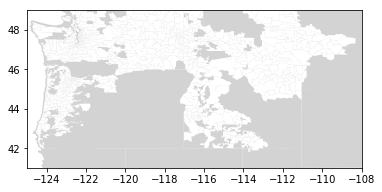

In [13]:
base = states.plot(color="lightgrey")
zip3.plot(ax=base,color="white")
base.set_xlim([-125,-108])
base.set_ylim([41,49])

Now we can transfer the demographic data at the city level and merge it into the 5-digit zipcode data.

In [14]:
keys = [int(x) for x in zipcode_gdf.index.to_list()]
zip5 = zipcode_gdf.set_index(pd.Index(keys))
zip5.index.name = "Zipcode"
zip5["Area"] = list(map(lambda x: int(str(x)[0:3]),zip5.index))
zip5 = zip5.merge(demographics,how="right",on="Zipcode")

We then plot the population densities, building occupancy, mediam home value, and median home income in the zipcodes where RBSA data is available.

Population density (per square mile)


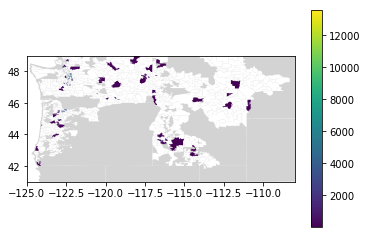

In [13]:
base = states.plot(color="lightgrey")
zip3.plot(ax=base,color="white")
base.set_xlim([-125,-108])
base.set_ylim([41,49])
zip5.plot(ax=base,column="Density",legend=True)
print("Population density (per square mile)")

Building occupancy (1-vacancy rate)


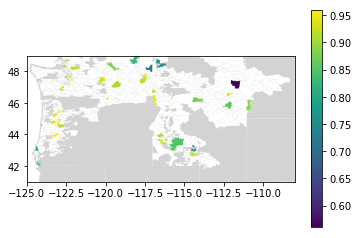

In [14]:
base = states.plot(color="lightgrey")
zip3.plot(ax=base,color="white")
base.set_xlim([-125,-108])
base.set_ylim([41,49])
zip5.plot(ax=base,column="Occupancy",legend=True)
print("Building occupancy (1-vacancy rate)")

Median home value (thousands US dollars)


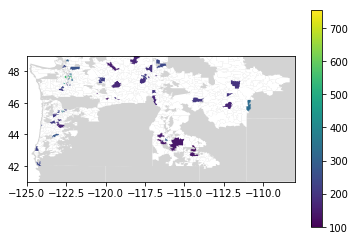

In [15]:
base = states.plot(color="lightgrey")
zip3.plot(ax=base,color="white")
base.set_xlim([-125,-108])
base.set_ylim([41,49])
zip5.plot(ax=base,column="Value",legend=True)
print("Median home value (thousands US dollars)")

Median home income (thousands of US dollars per year)


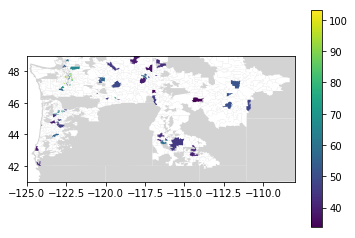

In [16]:
base = states.plot(color="lightgrey")
zip3.plot(ax=base,color="white")
base.set_xlim([-125,-108])
base.set_ylim([41,49])
zip5.plot(ax=base,column="Income",legend=True)
print("Median home income (thousands of US dollars per year)")

We now need to aggregate these demogaphic metrics by 3-digit zipcode.  The aggregation formula is weighted by population. 

(41, 49)

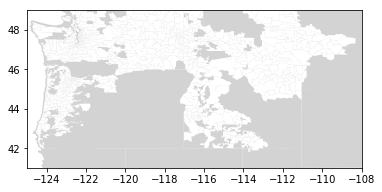

In [17]:
base = states.plot(color="lightgrey")
zip3.plot(ax=base,color="white")
base.set_xlim([-125,-108])
base.set_ylim([41,49])
#zip5.groupby("Area")["Population"].sum()

We calculate the population totals for each 3-digit zipcode area.

In [18]:
zipcode = zipcode_gdf
#zipcode["Area"] = list(map(lambda x: int(str(x)[0:3]),zipcode.index))
#zipcode = zipcode.merge(demographics,on="Zipcode")
#zipcode.head()
#zip5area = zipcode_gdf.groupby("Area")
#zip3pop = pd.DataFrame(zip5area["Population"].sum())
#zip5pop = pd.DataFrame(zipcode_gdf["Population"])

Then we calculate the population weighted average income for each area and merge the result into the 3-digit zipcode data.

In [19]:
zip5inc = pd.DataFrame(zip5["Income"]).mul(zip5["Population"],axis="index")
zip5inc["Area"] = list(map(lambda x: int(str(x)[0:3]),zip5inc.index))
zip5inc = zip5inc.groupby("Area").sum().div(zip3pop["Population"],axis="index")
zip3.loc[zip3.index,"Area"] = list(map(lambda x: int(str(x)[0:3]),zip3.index))
zip3data = zip3.merge(zip5inc,on="Area")
zip3data.head()

NameError: name 'zip3pop' is not defined

In [ ]:
base = states.plot(color="lightgrey")
base.set_xlim([-125,-108])
base.set_ylim([41,49])
zip3data.plot(ax=base,column="Income",legend=True)